In [28]:
#imports
import torch
import clip
from PIL import Image
import json
import glob
import matplotlib.pyplot as plt
import math

In [2]:
#load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

In [4]:
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

caption_ids = []
for x in data['images']:
    if x.get('split') == 'test':
        for i in range(len(x.get('sentences'))):
            caption_ids.append(int(x['filename'][:-4]))
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
    
captions = [x.get('raw') for x in captions]

# 1 caption is too long, this shortens it to prevent errors
string = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'
captions[3905] = string

In [5]:
# load images
images = []
image_ids = []
i = 0
for filename in glob.glob('datasets/flickr30k/test/*.jpg'):
    image_ids.append(int(filename[24:-4]))
    im=preprocess(Image.open(filename))
    images.append(im)
    i+=1
    if (i%250) == 0:
        print(i,"/1000", end='\r')
        
image_ids = torch.Tensor(image_ids)

In [14]:
image_RA1 = []
image_RA5 = []
image_RA10 = []
text_RA1 = []
text_RA5 = []
text_RA10 = []
for epoch in range(46):
    print("testing epoch:", epoch)
    checkpoint = torch.load("Models/"+str(epoch)+".pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    #encode images
    test_images = torch.Tensor().to(device)
    with torch.no_grad():
        print("0 /",len(images), end='\r')
        for i in range(0, len(images), 64):
            ims=model.encode_image(torch.stack(images[i:i+64]).to(device))
            test_images = torch.cat((test_images, ims), 0)
            if (i%128) == 0:
                print(i,"/",len(images), end='\r')

        print("1000 /",len(images), end='\r')

    test_images /= test_images.norm(dim=-1, keepdim=True)
    encoded_images = test_images
    print("")

    # encode captions
    text = clip.tokenize(captions).to(device)
    test_captions = torch.Tensor().to(device)
    with torch.no_grad():
        print("0 / 5000", end='\r')
        for i in range(0, len(text), 128):
            ts = model.encode_text(text[i:i+128])
            test_captions = torch.cat((test_captions, ts), 0)
            if (i%512) == 0:
                print(i,"/",len(text), end='\r')

        print("5000 / 5000", end='\r')

    text_features = test_captions
    text_features /= text_features.norm(dim=-1, keepdim=True)
    encoded_captions = list(zip(caption_ids, text_features))
    
    # get recall scores for current model(/epoch) (text to image)
    recall_1 = []
    recall_5 = []
    recall_10 = []
    for image_id, text_feature in encoded_captions: 
        similarity = (100.0 * text_feature @ encoded_images.T).softmax(dim=-1)
        
        values, indices = similarity.topk(1)
        recall_1.append(image_id in image_ids[indices])
        
        values, indices = similarity.topk(5)
        recall_5.append(image_id in image_ids[indices])
    
        values, indices = similarity.topk(10)
        recall_10.append(image_id in image_ids[indices])

    recall_1 = torch.Tensor(recall_1)
    image_RA1.append(recall_1.mean())
    
    recall_5 = torch.Tensor(recall_5)
    image_RA5.append(recall_5.mean())
    
    recall_10 = torch.Tensor(recall_10)
    image_RA10.append(recall_10.mean())

    # get recall scores for current model(/epoch) (image to text)
    recall_1 = []
    recall_5 = []
    recall_10 = []
    for i, image in enumerate(encoded_images): 
        similarity = (100.0 * image @ text_features.T).softmax(dim=-1)
        
        values, indices = similarity.topk(1)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_1.append(image_ids[i] in im_ids)
        
        values, indices = similarity.topk(5)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_5.append(image_ids[i] in im_ids)
        
        values, indices = similarity.topk(10)
        im_ids = []
        for indice in indices:
            im_ids.append(caption_ids[indice])
        recall_10.append(image_ids[i] in im_ids)

    recall_1 = torch.Tensor(recall_1)
    text_RA1.append(recall_1.mean())
    
    recall_5 = torch.Tensor(recall_5)
    text_RA5.append(recall_5.mean())
    
    recall_10 = torch.Tensor(recall_10)
    text_RA10.append(recall_10.mean())
    print("")

testing epoch: 0
1000 / 1000
5000 / 5000
testing epoch: 1
1000 / 1000/ 1000
5000 / 5000
testing epoch: 2
1000 / 1000/ 1000
5000 / 5000
testing epoch: 3
1000 / 1000/ 1000
5000 / 5000
testing epoch: 4
1000 / 1000
5000 / 5000
testing epoch: 5
1000 / 1000
5000 / 5000
testing epoch: 6
1000 / 1000
5000 / 5000
testing epoch: 7
1000 / 1000
5000 / 5000
testing epoch: 8
1000 / 1000/ 1000
5000 / 5000
testing epoch: 9
1000 / 1000
5000 / 5000
testing epoch: 10
1000 / 1000/ 1000
5000 / 5000
testing epoch: 11
1000 / 1000/ 1000 / 1000
5000 / 5000
testing epoch: 12
1000 / 1000
5000 / 5000
testing epoch: 13
1000 / 1000
5000 / 5000
testing epoch: 14
1000 / 1000
5000 / 5000
testing epoch: 15
1000 / 1000/ 1000
5000 / 5000
testing epoch: 16
1000 / 1000
5000 / 5000
testing epoch: 17
1000 / 1000
5000 / 5000
testing epoch: 18
1000 / 1000/ 1000
5000 / 5000
testing epoch: 19
1000 / 1000
5000 / 5000
testing epoch: 20
1000 / 1000
5000 / 5000
testing epoch: 21
1000 / 1000
5000 / 5000
testing epoch: 22
1000 / 1000
5

In [42]:
indexes = [0,5,10,15,20,25,30,35,40,45]
print("R@1 img retrieval:", ["%.4f" % image_RA1[idx].item() for idx in indexes])
print("R@5 img retrieval:", ["%.4f" % image_RA5[idx].item() for idx in indexes])
print("R@10 img retrieval:", ["%.4f" % image_RA10[idx].item() for idx in indexes])
print("R@1 txt retrieval:", ["%.4f" % text_RA1[idx].item() for idx in indexes])
print("R@5 txt retrieval:", ["%.4f" % text_RA5[idx].item() for idx in indexes])
print("R@10 txt retrieval:", ["%.4f" % text_RA10[idx].item() for idx in indexes])

R@1 img retrieval: ['0.6026', '0.6254', '0.6358', '0.6424', '0.6488', '0.6524', '0.6558', '0.6588', '0.6628', '0.6656']
R@5 img retrieval: ['0.8438', '0.8630', '0.8710', '0.8750', '0.8768', '0.8802', '0.8810', '0.8828', '0.8842', '0.8856']
R@10 img retrieval: ['0.9070', '0.9204', '0.9262', '0.9292', '0.9314', '0.9318', '0.9332', '0.9344', '0.9366', '0.9368']
R@1 txt retrieval: ['0.7980', '0.8080', '0.8160', '0.8210', '0.8270', '0.8320', '0.8310', '0.8350', '0.8350', '0.8350']
R@5 txt retrieval: ['0.9560', '0.9650', '0.9680', '0.9710', '0.9720', '0.9710', '0.9710', '0.9720', '0.9720', '0.9740']
R@10 txt retrieval: ['0.9870', '0.9880', '0.9900', '0.9910', '0.9900', '0.9890', '0.9900', '0.9920', '0.9920', '0.9920']


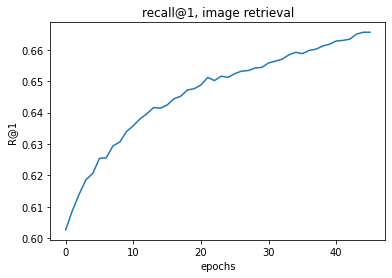

In [16]:
plt.plot(image_RA1)
plt.title("recall@1, image retrieval")
plt.xlabel('epochs')
plt.ylabel('R@1')
plt.show()

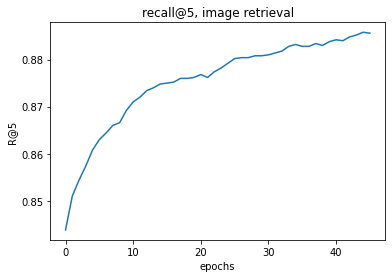

In [18]:
plt.plot(image_RA5)
plt.title("recall@5, image retrieval")
plt.xlabel('epochs')
plt.ylabel('R@5')
plt.show()

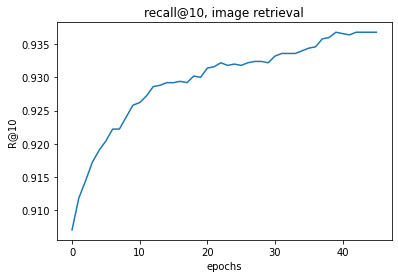

In [19]:
plt.plot(image_RA10)
plt.title("recall@10, image retrieval")
plt.xlabel('epochs')
plt.ylabel('R@10')
plt.show()

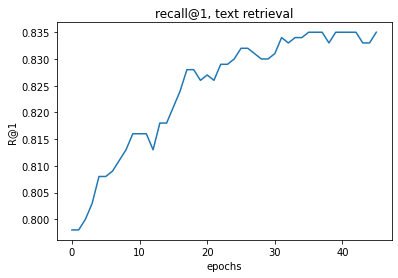

In [20]:
plt.plot(text_RA1)
plt.title("recall@1, text retrieval")
plt.xlabel('epochs')
plt.ylabel('R@1')
plt.show()

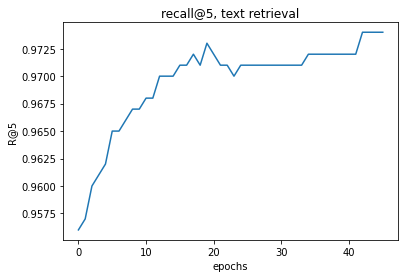

In [21]:
plt.plot(text_RA5)
plt.title("recall@5, text retrieval")
plt.xlabel('epochs')
plt.ylabel('R@5')
plt.show()

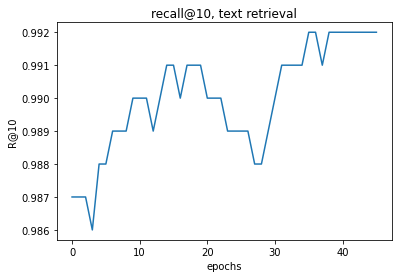

In [22]:
plt.plot(text_RA10)
plt.title("recall@10, text retrieval")
plt.xlabel('epochs')
plt.ylabel('R@10')
plt.show()

In [6]:
test_images = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(images), 64):
        ims=model.encode_image(torch.stack(images[i:i+64]).to(device))
        test_images = torch.cat((test_images, ims), 0)
        if (i%128) == 0:
            print(i,"/",len(images), end='\r')
            
    print("1000 /",len(images), end='\r')
            
test_images /= test_images.norm(dim=-1, keepdim=True)
encoded_images = test_images
print("")
print("done")

1000 / 1000000
done


In [16]:
text = clip.tokenize(captions).to(device)

# encode captions
test_captions = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(text), 128):
        ts = model.encode_text(text[i:i+128])
        test_captions = torch.cat((test_captions, ts), 0)
        if (i%512) == 0:
            print(i,"/",len(text), end='\r')
        
    print("5000 / 5000", end='\r')

text_features = test_captions
text_features /= text_features.norm(dim=-1, keepdim=True)

print("")
print("done")

5000 / 5000
done
